# *CIFAR-100*  

- Quantity: 60.000 images (50.000 train, 10.000 test)
- Size: 32x32x3 (RGB)
- Label: 100 classes -> 20 superclasses

In [2]:
import torch
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
from collections import Counter
import seaborn as sns


## Load dataset


In [3]:

PATH = r'..\datasets'

trainset = torchvision.datasets.CIFAR100(root=PATH, train=True, download=False)
testset = torchvision.datasets.CIFAR100(root=PATH, train=False, download=False)
    
print(f"Train images: {len(trainset)}")
print(f"Test images: {len(testset)}")



Train images: 50000
Test images: 10000


In [ ]:
print("--- Dataset Overview ---")
print(f"Training data shape: {trainset.data.shape}") # Hình dạng mảng dữ liệu train
print(f"Number of training labels: {len(np.array(trainset.targets))}") # Tổng số nhãn train
print(f"Number of classes: {len(trainset.classes)}") 
print(f"Example of a label (class ID): {np.array(trainset.targets)[0]}")

--- Dataset Overview ---
Training data shape: (50000, 32, 32, 3)
Number of training labels: 50000
Number of classes: 100
Example of a label (class ID): 19


## Label Distribution

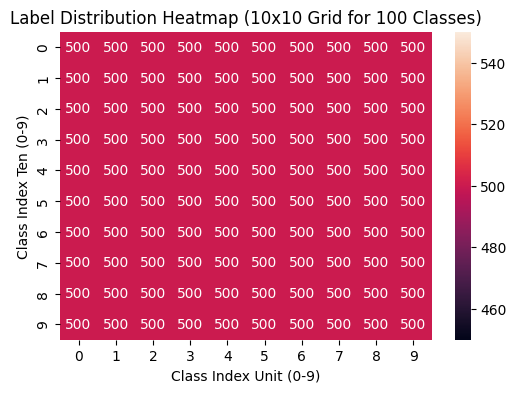

In [6]:
# Đếm số lượng mẫu
unique, counts = np.unique(trainset.targets, return_counts=True)
# Reshape 100 lớp thành ma trận 10x10
counts_matrix = counts.reshape(10, 10)

plt.figure(figsize=(6, 4))
sns.heatmap(counts_matrix, annot=True, fmt="d")

plt.title("Label Distribution Heatmap (10x10 Grid for 100 Classes)")
plt.xlabel("Class Index Unit (0-9)")
plt.ylabel("Class Index Ten (0-9)")
plt.show()

Nhận xét: CIFAR-100 là một dataset cân bằng hoàn hảo (500 ảnh/lớp ở tập train)

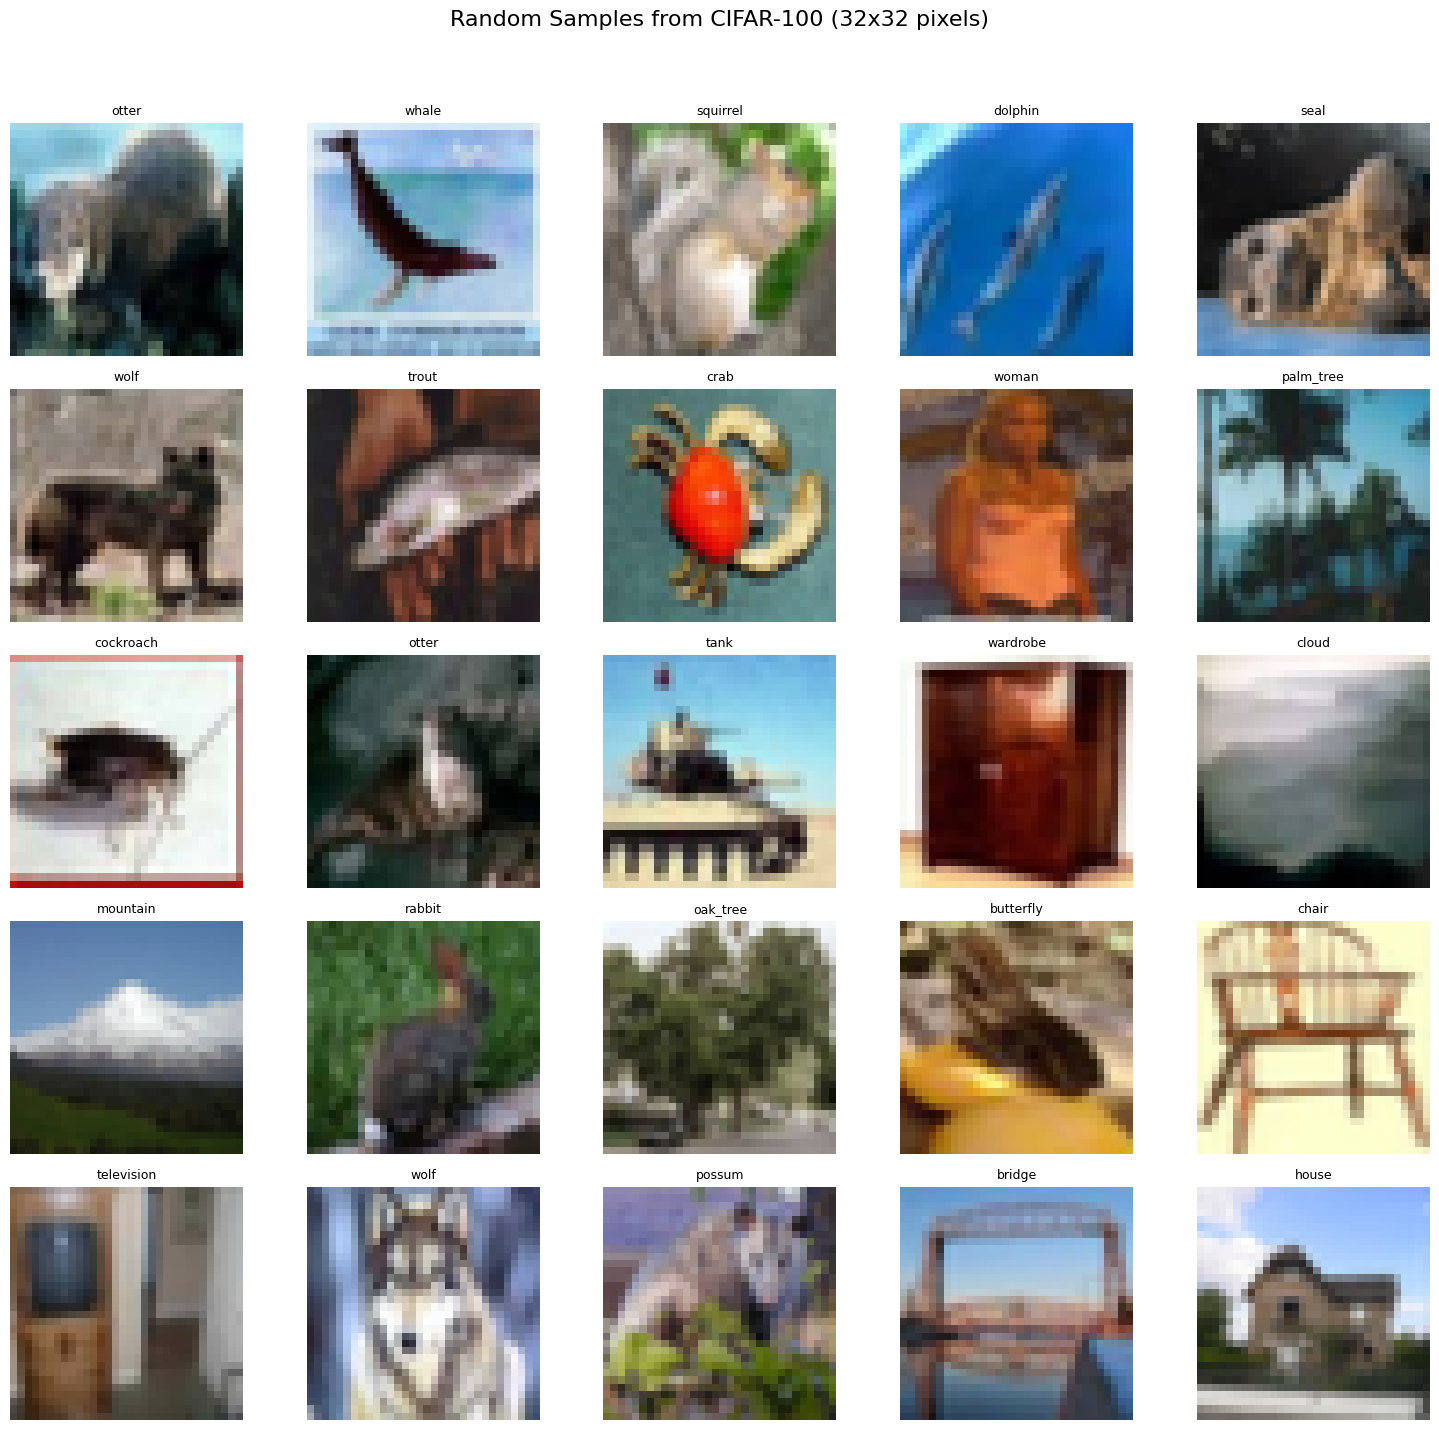

In [9]:
# Lấy danh sách tên các lớp từ thuộc tính classes của dataset
class_names = trainset.classes

plt.figure(figsize=(15, 15))
for i in range(25):
    plt.subplot(5, 5, i+1)
    idx = np.random.randint(0, len(trainset.data))
    
    # Hiển thị ảnh
    plt.imshow(trainset.data[idx])
    
    # Lấy tên lớp tương ứng
    label_idx = trainset.targets[idx]
    plt.title(f"{class_names[label_idx]}", fontsize=9)
    plt.axis('off')

plt.suptitle("Random Samples from CIFAR-100 (32x32 pixels)", fontsize=16)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

## Pixel Intensity Analysis

Phân tích điểm ảnh giúp xác định các thông số (Mean, Std) để chuẩn hóa dữ liệu về cùng một thang đo, từ đó giúp mô hình hội tụ nhanh hơn và đạt hiệu suất ổn định hơn.

Bộ thông số chuẩn của CIFAR-100
- Mean: [0.5071, 0.4867, 0.4408]
- Std: [0.2675, 0.2565, 0.2761]

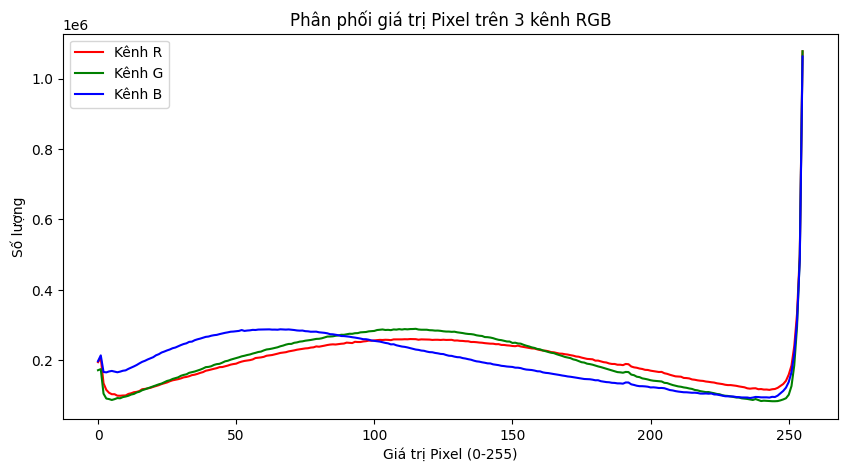

Giá trị trung bình từng kênh (R, G, B): [129.30416561 124.0699627  112.43405006]
Độ lệch chuẩn từng kênh (R, G, B): [68.1702429  65.39180804 70.41837019]


In [14]:
def plot_color_distribution(data):
    colors = ('r', 'g', 'b')
    plt.figure(figsize=(10, 5))
    for i, col in enumerate(colors):
        # Tính histogram cho từng kênh màu
        hist = np.histogram(data[:, :, :, i], bins=256, range=(0, 256))[0]
        plt.plot(hist, color=col, label=f'Kênh {col.upper()}')
    
    plt.title("Phân phối giá trị Pixel trên 3 kênh RGB")
    plt.xlabel("Giá trị Pixel (0-255)")
    plt.ylabel("Số lượng")
    plt.legend()
    plt.show()

plot_color_distribution(trainset.data)

# Tính Mean và Std để dùng cho Normalization sau này
mean = np.mean(trainset.data, axis=(0, 1, 2))
std = np.std(trainset.data, axis=(0, 1, 2))
print(f"Giá trị trung bình từng kênh (R, G, B): {mean}")
print(f"Độ lệch chuẩn từng kênh (R, G, B): {std}")

## Visualizing Clusters

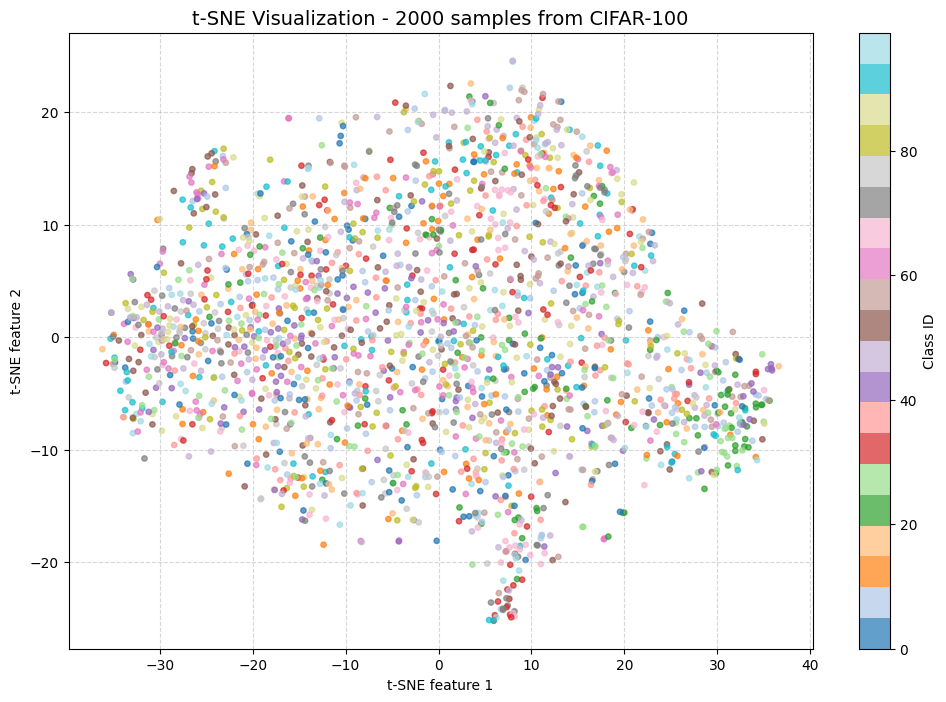

In [ ]:
from sklearn.manifold import TSNE
import pandas as pd

# Lấy mẫu dữ liệu 
n_samples = 2000
x_subset = trainset.data[:n_samples]
y_subset = np.array(trainset.targets[:n_samples])

# Flatten ảnh và chuẩn hóa về [0, 1]
x_subset_flat = x_subset.reshape(n_samples, -1) / 255.0

tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
x_tsne = tsne.fit_transform(x_subset_flat)

plt.figure(figsize=(12, 8))

scatter = plt.scatter(x_tsne[:, 0], x_tsne[:, 1], c=y_subset, cmap='tab20', s=15, alpha=0.7)

# Thêm thanh màu để biết nhãn tương ứng 
plt.colorbar(scatter, label='Class ID')
plt.title(f"t-SNE Visualization - {n_samples} samples from CIFAR-100", fontsize=14)
plt.xlabel("t-SNE feature 1")
plt.ylabel("t-SNE feature 2")
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

- Các lớp đang chồng lấn (overlap) hoàn toàn lên nhau.
- Các ảnh trong CIFAR-100 có màu sắc và bố cục quá đa dạng. Việc các chấm màu trộn lẫn cho thấy "khoảng cách" giữa các tấm ảnh cùng loại không gần nhau hơn so với các tấm ảnh khác loại ở mức độ pixel.

SupperClass

In [18]:
import pickle
import os
import numpy as np

# Đường dẫn đến folder mà torchvision đã tạo ra
folder_path = os.path.join(PATH, 'cifar-100-python')

# 1. Load nhãn siêu lớp (coarse_labels) cho tập train
with open(os.path.join(folder_path, 'train'), 'rb') as f:
    train_data = pickle.load(f, encoding='latin1')
    y_train_coarse = np.array(train_data['coarse_labels'])

# 2. Load tên của 20 siêu lớp từ file meta
with open(os.path.join(folder_path, 'meta'), 'rb') as f:
    meta_data = pickle.load(f, encoding='latin1')
    superclass_names = meta_data['coarse_label_names']

print(f"Danh sách 20 siêu lớp: {superclass_names}")

Danh sách 20 siêu lớp: ['aquatic_mammals', 'fish', 'flowers', 'food_containers', 'fruit_and_vegetables', 'household_electrical_devices', 'household_furniture', 'insects', 'large_carnivores', 'large_man-made_outdoor_things', 'large_natural_outdoor_scenes', 'large_omnivores_and_herbivores', 'medium_mammals', 'non-insect_invertebrates', 'people', 'reptiles', 'small_mammals', 'trees', 'vehicles_1', 'vehicles_2']


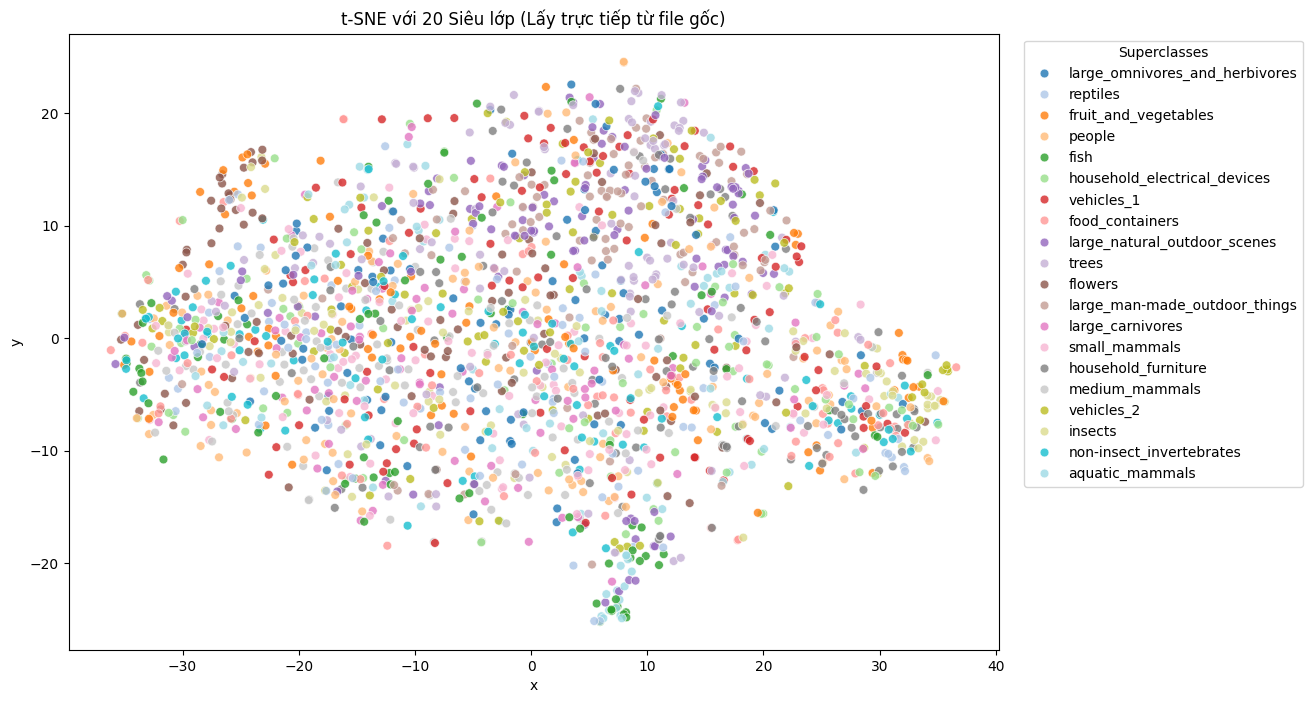

In [19]:

# Lấy 2000 mẫu để trực quan hóa
n_samples = 2000
x_subset = trainset.data[:n_samples].reshape(n_samples, -1) / 255.0
y_subset = y_train_coarse[:n_samples]

# Chạy t-SNE
tsne = TSNE(n_components=2, random_state=42, init='pca', learning_rate='auto')
x_tsne = tsne.fit_transform(x_subset)

# Tạo DataFrame để vẽ
df = pd.DataFrame({
    'x': x_tsne[:, 0],
    'y': x_tsne[:, 1],
    'label': [superclass_names[i] for i in y_subset]
})

# Vẽ biểu đồ
plt.figure(figsize=(12, 8))
sns.scatterplot(data=df, x='x', y='y', hue='label', palette='tab20', s=40, alpha=0.8)
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', title="Superclasses")
plt.title(f"t-SNE với 20 Siêu lớp (Lấy trực tiếp từ file gốc)")
plt.show()

## Mean Image

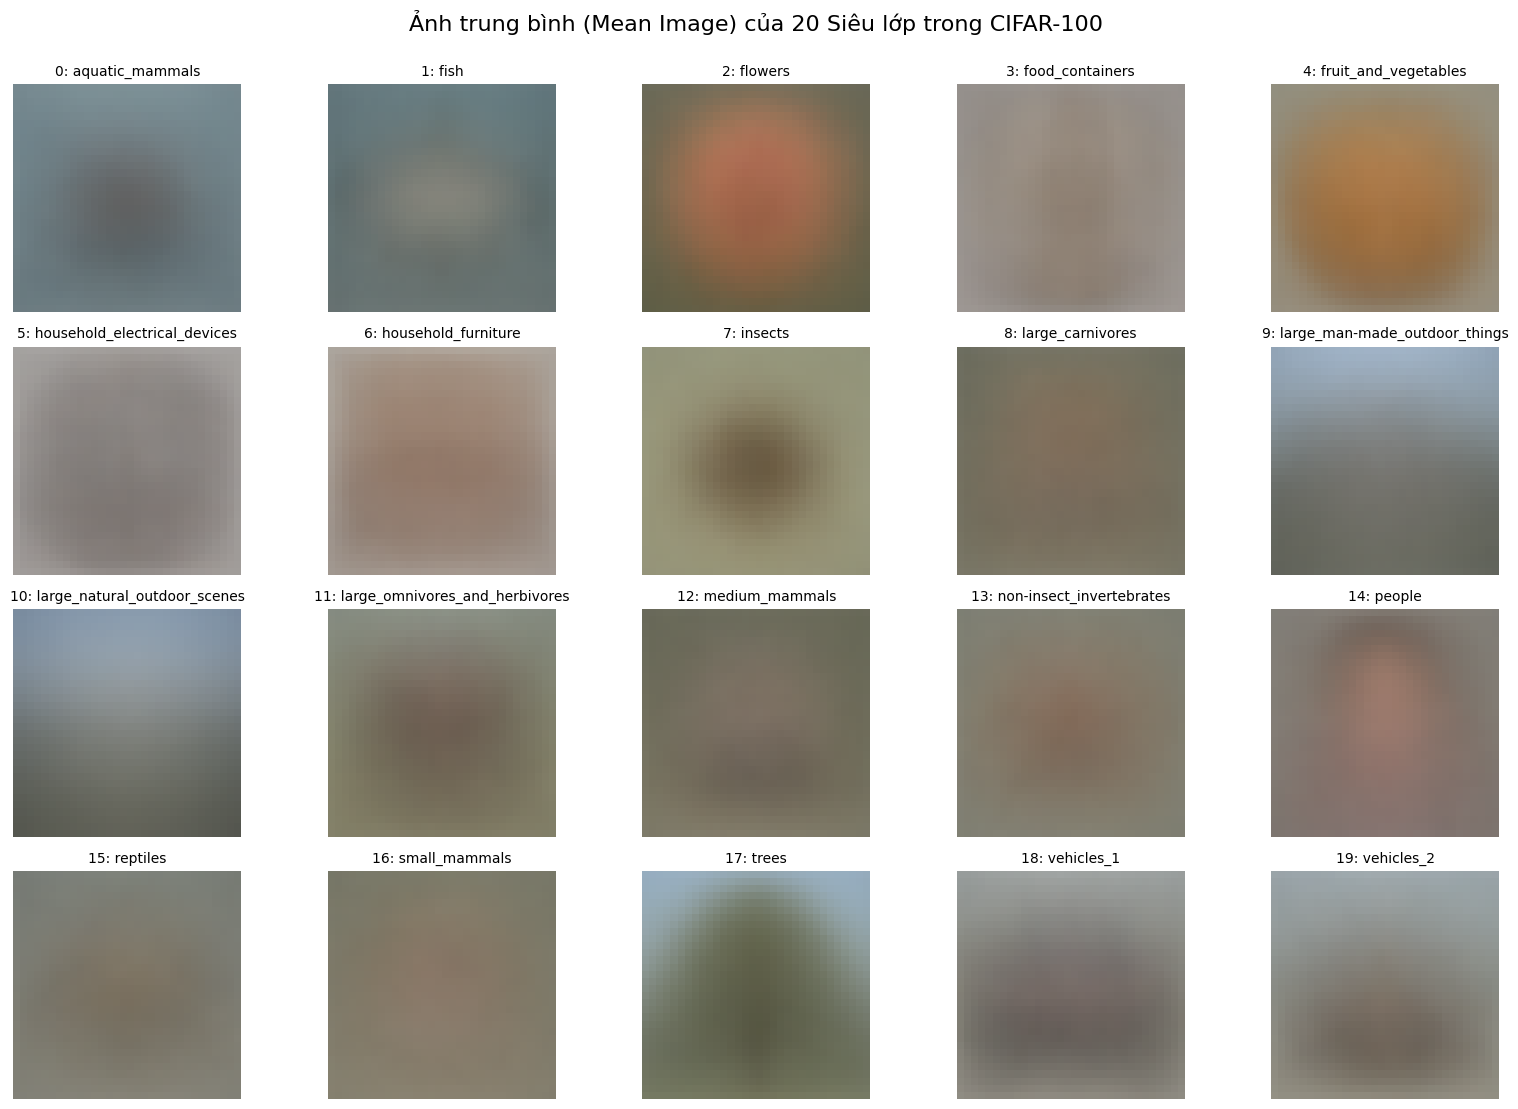

In [ ]:
plt.figure(figsize=(16, 12))

for i in range(20):
    idx = np.where(y_train_coarse == i)[0]
    class_images = trainset.data[idx]
    
    # Tính trung bình cộng theo trục dọc (axis=0)
    # Kết quả là một ma trận 32x32x3
    mean_img = np.mean(class_images, axis=0).astype(np.uint8)
    
    plt.subplot(4, 5, i+1)
    plt.imshow(mean_img)
    plt.title(f"{i}: {superclass_names[i]}", fontsize=10)
    plt.axis('off')

plt.suptitle("Ảnh trung bình (Mean Image) của 20 Siêu lớp trong CIFAR-100", fontsize=16, y=0.95)
plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()

- Cấu trúc hình học: Nếu ảnh trung bình hiện ra một hình khối mờ (như hình bầu dục ở giữa), chứng tỏ các đối tượng trong lớp đó thường nằm ở trung tâm
- Màu sắc chủ đạo:'trees' (cây) sẽ có màu xanh lá cây đặc trưng; 